In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # rgb 平均值 方差
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    ]
)

# 训练数据集
trainset = torchvision.datasets.CIFAR10(root="./data",
                                        train=True,
                                        download=True,
                                        transform=transform,
                                        )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# 训练数据集
testset = torchvision.datasets.CIFAR10(root="./data",
                                       train=False,
                                       download=True,
                                       transform=transform,
                                       )
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


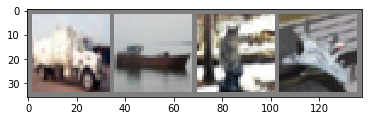

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # 输入数据
    img = img / 2 + 0.5
    nping = img.numpy()
    nping = np.transpose(nping, (1, 2, 0))  # [h,w,c]
    plt.imshow(nping)

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):  # 定义神经网络结构,输入数据 3x32x32
        super(Net, self).__init__()
        # 第一层 卷积层
        self.conv1 = nn.Conv2d(3, 6, 3)  # 输入频道3 输出频道6 卷积 3x3
        # 第二层 卷积层
        self.conv2 = nn.Conv2d(6, 16, 3)  # 输入频道6 输出频道16 卷积 3x3
        # 第三层 全连接层
        # 32经过2次卷积 每次卷积以后减2 32 -2 -2 =28
        self.fc1 = nn.Linear(16 * 28 * 28, 512)  # 输入维度 16x28x28=12544 输出维度 512
        # 第四层 全连接层
        self.fc2 = nn.Linear(512, 64)  # 输入维度512 输出维度64
        # 第五层 全连接层
        self.fc3 = nn.Linear(64, 10)  # 输入维度64 输出维度10

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = x.view(-1, 16 * 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x




In [26]:
net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [27]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

# if(torch.cuda.is_available()):
#     net = torch.nn.DataParallel(net, device_ids=[0]).cuda()

In [3]:
train_loss_hist = []
test_loss_hist = []
for epoch in range(20):
    #训练
    net.train()
    running_loss = 0.0
    for i , data in enumerate(trainloader):
        images , labels = data
        outputs = net(images)
        loss = criterion(outputs,labels) # 计算损失
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if( i%250 == 0 ):
            correct = 0.0
            total = 0.0
            net.eval()
            with torch.no_grad:
                for test_data in testloader:
                    test_images,test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs,test_labels)
            
            train_loss_hist.append(running_loss/250)
            test_loss_hist.append(test_loss.item())
            running_loss = 0.0
            print('Epoch: %d, Step: %d, Loss: %.3f' % (epoch,i,loss.item()) )

NameError: name 'net' is not defined

Text(0, 0.5, 'Loss')

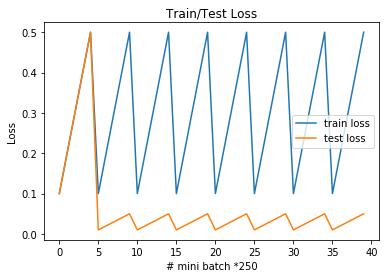

In [18]:
plt.figure()
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.legend(("train loss","test loss"))
plt.title("Train/Test Loss")
plt.xlabel("# mini batch *250")
plt.ylabel("Loss")


In [28]:
# 测试模型
correct = 0.0
total = 0.0
with torch.no_grad():
    for data in  testloader:
        images , labels = data
        outputs = net(images)
        
        _,predicted = torch.max(outputs.data,1)
        correct  += (predicted==labels).sum()
        total += labels.size(0)

print("精确率:",float(correct / total))

精确率: 0.10109999775886536


In [31]:
# 保存模型
torch.save(net.state_dict(),"./model.pt")



In [33]:
# 读取模型
net_2 = Net()
net_2.load_state_dict(torch.load("./model.pt"))
correct = 0.0
total = 0.0
with torch.no_grad():
    for data in  testloader:
        images , labels = data
        outputs = net(images)
        
        _,predicted = torch.max(outputs.data,1)
        correct  += (predicted==labels).sum()
        total += labels.size(0)

print("精确率:",float(correct / total))


精确率: 0.10109999775886536
